In [1]:
# To define the fragmentation algorithm
"""
import inspect

params = BRICSScaffoldParams()

attributes=[a for a in inspect.getmembers(params) if not(a[0].startswith('__'))]
print('params default attributes:')
for a in attributes:
    print('{0}: {1}'.format(a[0],a[1]))
"""

"\nimport inspect\n\nparams = BRICSScaffoldParams()\n\nattributes=[a for a in inspect.getmembers(params) if not(a[0].startswith('__'))]\nprint('params default attributes:')\nfor a in attributes:\n    print('{0}: {1}'.format(a[0],a[1]))\n"

In [2]:
# Implementing murcko side chain comparison

In [3]:
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
import pandas as pd

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

In [4]:
import time
start_time = time.time()

In [5]:
#This is a cleaned cluster
#cluster_path = "../clusters/cls-22-06-28/cls10/cluster_cleaned.csv"
cluster_path = "../clusters/very_large-22-06-28/cluster_cleaned.csv"
df = pd.read_csv(cluster_path, index_col="index")
show_df(df.head())

,CID,SMILES
index,,
19585,PET-UNK-c0891748-7,COC1(C(=O)Nc2cncc3ccccc23)CCOc2ncc(Cl)cc21
13678,ALP-POS-477dc5b7-3,O=C(Nc1cncc2ccccc12)C1(CCC2CC2)CCOc2ccc(Cl)cc21
13754,DAR-DIA-6a508060-10,CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21
13757,DAR-DIA-6a508060-13,CS(=O)(=O)NCCC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(...
15803,MAT-POS-5d65ec79-1,CN(C)C(=O)CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl...


In [6]:
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')

In [7]:
#show_df(df.head())

In [8]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Scaffolds import rdScaffoldNetwork
from rdkit.Chem.Scaffolds.rdScaffoldNetwork import *

In [9]:
import dataframe_image as dfi

In [10]:
# Add murcko scaffold column to dataset
#MurckoScaffold.GetScaffoldForMol(df.iloc[0]["Molecule"])

df["murcko"] = df.apply(lambda x: MurckoScaffold.GetScaffoldForMol(x["Molecule"]), axis = 1)
df["generic_murcko"] = df.apply(lambda x: MurckoScaffold.MakeScaffoldGeneric(x["murcko"]), axis = 1)
#show_df(df[["Molecule","murcko", "generic_murcko"]])

#dfi.export((df[["Molecule","murcko", "generic murcko"]].head()),"simple_murcko_scaffolds.png")

In [11]:
# Proof of concept with simple murcko

In [12]:
core = df.iloc[0]["murcko"]
#core = df.iloc[0]["generic murcko"]
mol = df.iloc[0]["Molecule"]

In [13]:
from rdkit.Chem.rdmolops import ReplaceCore
from rdkit.Chem import rdFMCS

In [14]:
core = df.iloc[0]["murcko"]
mol = df.iloc[0]["Molecule"]
side_chains = ReplaceCore(mol,core, mol.GetSubstructMatch(core))

In [15]:
def getSideChainsFromScaffold(mol, core):
    return(ReplaceCore(mol,core, mol.GetSubstructMatch(core)))
    
def getSideChains(mol):
    core = MurckoScaffold.GetScaffoldForMol(mol)
    return(ReplaceCore(mol,core, mol.GetSubstructMatch(core)))

In [16]:
#getSideChains(df.iloc[4]["Molecule"])

In [17]:
#df["side_chains"] = df.apply(lambda x: getSideChainsFromScaffold(x["Molecule"], core), axis = 1)
df["side_chains"] = df.apply(lambda x: getSideChains(x["Molecule"]), axis = 1)

In [18]:
#show_df(df[["Molecule","murcko", "generic_murcko", "side_chains"]])

In [19]:
#dfi.export((df[["Molecule","murcko", "generic murcko", "side_chains"]].head()),"simple_murcko_sidechains_single_core.png")

In [20]:
#side_chains_1 = df.iloc[0]["side_chains"]
#side_chains_2 = df.iloc[1]["side_chains"]

In [21]:
import re

def getSideChainsSetFromSmiles(string, benzene_scaffold=False):
    """
    input: smiles string with multiple dumby atoms, indicating fragments side chains
    returns: set of just fragment (no dumby atom number)
    """
    # Note, dumby atom could be used in hash to retain pertubation location
    # However dumby number would have to be defined as carbon number
    # Note, set loses index ability
    
    lst = re.split('\.\[(?:[0-9])\*\]', string)
    lst.remove("")
    return set(lst)



def getSideChainsSetFromMol(side_chains, returnString=False):
    """
    input: rdkit mol object with multiple dumby atoms, indicating fragments side chains
    returns: set of just fragment (no dumby atom number)
    """
    # Note, dumby atom could be used in hash to retain pertubation location
    # However dumby number would have to be defined as carbon number
    # Note, set loses index ability
    string = Chem.MolToSmiles(side_chains,True) # Isomeric. May want non isomeric, set false
    if returnString:
        return string
    
    #Removing . indicating unbonded atoms
    string = string.replace(".","")
    lst = re.split('\[(?:[0-9])\*\]', string)
    lst.remove("")
             
    return set(lst)




def getSinglePertubation(set1, set2):
    #Line finds the non shared elements in two sets
    not_shared_side_chains = (set1 - set2).union(set2 - set1)
    
    #Assuming pertubations are only allowed in cases where one transformation is occuring
    #Hence set must have size 2
    if len(not_shared_side_chains) != 2:
        return None
    else:
        return not_shared_side_chains


In [22]:
# Smiles side chain set
df["side_chain_set"] = df.apply(lambda x: getSideChainsSetFromMol(x["side_chains"], returnString=False), axis = 1)

In [23]:
#show_df(df[["side_chains", "side_chain_set"]].head())

In [24]:
def GraftFragmentToBenzene(fragment):
    """
    Input: Fragment is string, without leading [1*]
    Output: Benzene scaffold
    """
    benzene = Chem.MolFromSmiles("C1=CC=CC=C1")
    fragment = '[1*]'+fragment
    fragment = Chem.MolFromSmiles(fragment)
    
    mod_mol = Chem.ReplaceSubstructs(fragment, 
                                 Chem.MolFromSmiles('[1*]'), 
                                 benzene,
                                 replaceAll=True
                                    )
    return mod_mol[0]

In [25]:
#Probs not best way 
graft_pair_df = pd.DataFrame(columns=["idx1","idx2","fragments","graft1","graft2"])

for i in range(len(df)):
    for j in range(i):
        fragments = getSinglePertubation(df.iloc[i]["side_chain_set"],df.iloc[j]["side_chain_set"])
        
        if fragments:
            fragments_list = list(fragments)
            graft1 = GraftFragmentToBenzene(fragments_list[0])
            graft2 = GraftFragmentToBenzene(fragments_list[1])

            row = {"idx1":df.index[i],"idx2":df.index[j],"fragments":fragments,"graft1":graft1,"graft2":graft2}
            graft_pair_df = graft_pair_df.append(row,ignore_index=True)

In [26]:
#show_df(graft_pair_df)

In [27]:
len(graft_pair_df)

1814

In [28]:
end_time = time.time()

In [29]:
print(end_time-start_time)

3.972780704498291


In [31]:
(80*80-80)/2

3160.0

,idx1,idx2,fragments,graft1,graft2
0,13754,19585,"{C, OC}",,
1,13757,19585,"{CCNS(C)(=O)=O, OC}",,
2,13757,13754,"{CCNS(C)(=O)=O, C}",,
3,15803,19585,"{CC(=O)N(C)C, OC}",,
4,15803,13754,"{CC(=O)N(C)C, C}",,
5,15803,13757,"{CCNS(C)(=O)=O, CC(=O)N(C)C}",,
6,15804,19585,"{CC(=O)NC, OC}",,
7,15804,13754,"{CC(=O)NC, C}",,
8,15804,13757,"{CCNS(C)(=O)=O, CC(=O)NC}",,
9,15804,15803,"{CC(=O)NC, CC(=O)N(C)C}",,

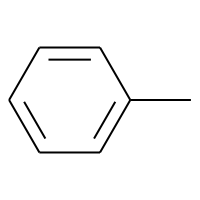
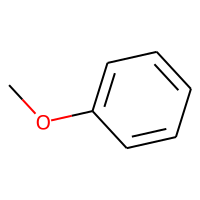
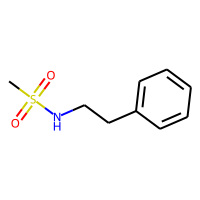
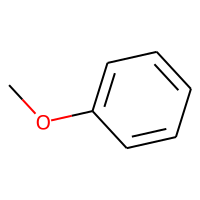
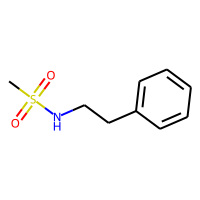
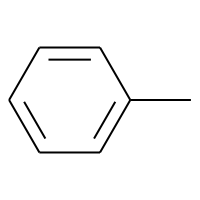
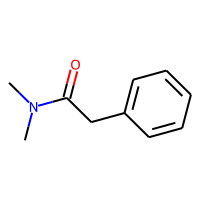
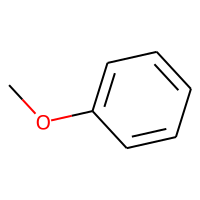
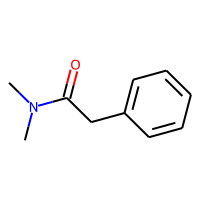
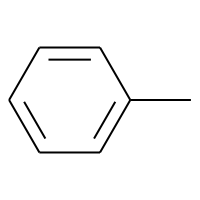
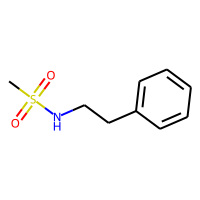
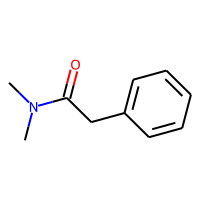
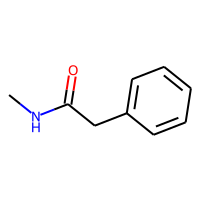
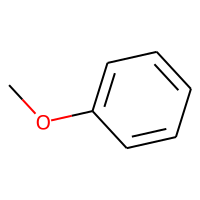
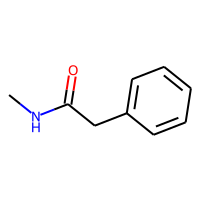
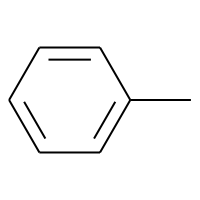
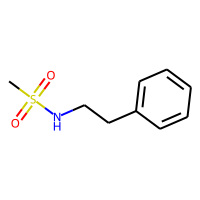
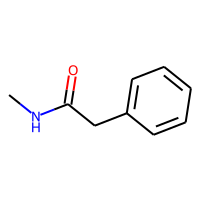
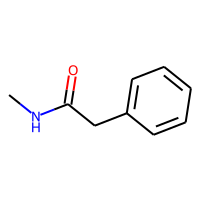
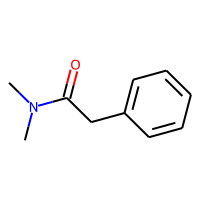
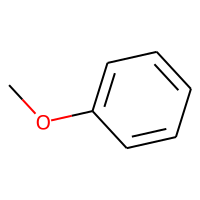
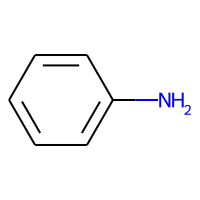
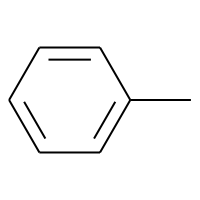
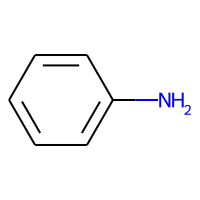
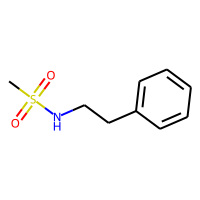
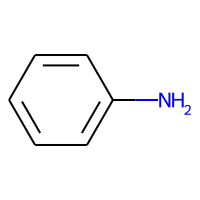
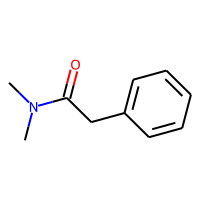
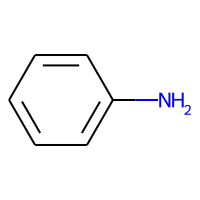
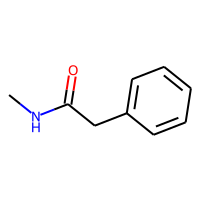
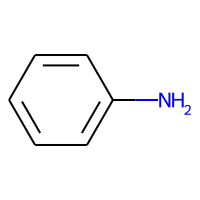
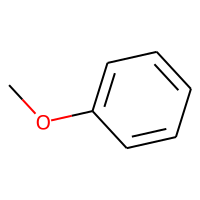
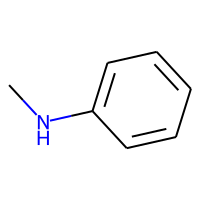
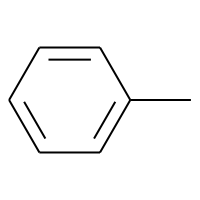
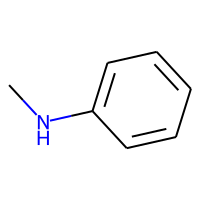
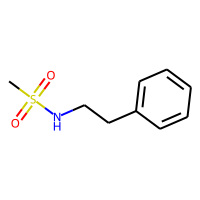
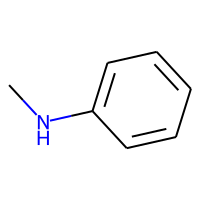
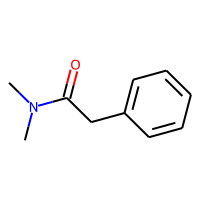
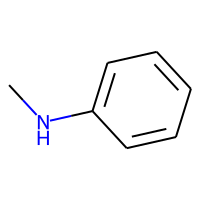
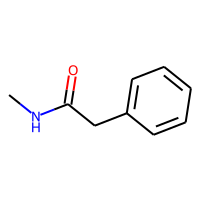
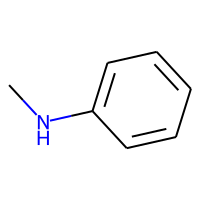

In [32]:
show_df(graft_pair_df.head(20))